<a href="https://colab.research.google.com/github/NREL/pysam/blob/pvpmc-workshop/Examples/PySAM_PVPMC_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PySAM Workshop

## PVPMC Conference, Salt Lake City, Utah

## May 10th, 2023

Matt Prilliman (Github: mjprilliman)
Nate Blair (n8blair)
Brian Mirletz (brtietz)
Darice Guittet (dguittet)
Janine Keith (janinefreeman)

https://sam.nrel.gov/software-development-kit-sdk/pysam.html

## PySAM Overview

PySAM is a Python package for the National Renewable Energy Laboratory’s System Advisor Model (SAM). It is part of the SAM Software Development Kit (SDK), which provides tools for developers who write code that interacts with the SAM Simulation Core (SSC) application programming interface (API).

SSC, SAM, and PySAM are NREL open source code projects hosted on GitHub.com.

## How to Get Started

64-bit Python 3.6 to 3.10 for Linux, Mac and Windows

PyPi: 
```
pip install nrel-pysam
```

Anaconda:
```
conda install -u nrel nrel-pysam
```

## Tutorial 1 Agenda

1. Getting started with PySAM
2. Set up solar resource data
3. Design PV System
4. Run Simulation, view outputs
5. Extended analysis features

In [13]:
# if running on Google Colaboratory, run this cell to install project dependencies
!pip install nrel-pysam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Getting Started with PySAM

Each technology and financial configuration is composed of unit modules. Module documentation is in [Modules](https://nrel-pysam.readthedocs.io/en/master/Models.html) or refer to [Module Index](https://nrel-pysam.readthedocs.io/en/master/py-modindex.html). 

Each module can be imported by:

```
import PySAM.<Module name>
```

There are four ways to initialize a model:

1. new
2. default
3. from_existing
4. wrap


In [14]:
import PySAM.Pvsamv1 as pv
import PySAM.Utilityrate5 as ur
import PySAM.Lcoefcr as lcoe
import PySAM.ResourceTools as resource_tools
import PySAM.Battery as batt
import PySAM.BatteryTools as batt_tools
import PySAM.Singleowner as so
import PySAM.Cashloan as cl
import matplotlib.pyplot as plt
import PySAM.Grid as grid
import numpy as np
import json
import pandas as pd

### Start model from new()

Creates an instance with empty attributes.

In [15]:
new_model = pv.new()
print(type(new_model))
new_model.export()

<class 'Pvsamv1'>


{'SolarResource': {},
 'Losses': {},
 'Lifetime': {},
 'SystemDesign': {},
 'Shading': {},
 'Layout': {},
 'Module': {},
 'SimpleEfficiencyModuleModel': {},
 'CECPerformanceModelWithModuleDatabase': {},
 'CECPerformanceModelWithUserEnteredSpecifications': {},
 'SandiaPVArrayPerformanceModelWithModuleDatabase': {},
 'IEC61853SingleDiodeModel': {},
 'MermoudLejeuneSingleDiodeModel': {},
 'Inverter': {},
 'InverterCECDatabase': {},
 'InverterCECCoefficientGenerator': {},
 'InverterDatasheet': {},
 'InverterPartLoadCurve': {},
 'InverterMermoudLejeuneModel': {},
 'BatterySystem': {},
 'Load': {},
 'BatteryCell': {},
 'BatteryDispatch': {},
 'SystemCosts': {},
 'FuelCell': {},
 'PriceSignal': {},
 'Revenue': {},
 'ElectricityRates': {},
 'GridLimits': {},
 'AdjustmentFactors': {},
 'Outputs': {}}

### Default

There is a lot of data needed to run a model. Entering that data with assignment statements in PySAM can be tedious. One way to get a full set of data is to load the default setup, which are the same as in SAM. A module's default values are unique for each SAM configuration type. 

Default config names are __case insensitive__. The list of options can be found on the module's PySAM doc page or as below:

In [16]:
# list configuration options
help(pv.default)

Help on built-in function default in module PySAM.Pvsamv1:

default(...)
    default(config) -> Pvsamv1
    
    Load defaults for the configuration ``config``. Available configurations are:
    
                    - *"FlatPlatePVAllEquityPartnershipFlip"*
    
                    - *"FlatPlatePVCommercial"*
    
                    - *"FlatPlatePVHostDeveloper"*
    
                    - *"FlatPlatePVLCOECalculator"*
    
                    - *"FlatPlatePVLeveragedPartnershipFlip"*
    
                    - *"FlatPlatePVMerchantPlant"*
    
                    - *"FlatPlatePVNone"*
    
                    - *"FlatPlatePVResidential"*
    
                    - *"FlatPlatePVSaleLeaseback"*
    
                    - *"FlatPlatePVSingleOwner"*
    
                    - *"FlatPlatePVThirdParty"*
    
                    - *"PVBatteryAllEquityPartnershipFlip"*
    
                    - *"PVBatteryCommercial"*
    
                    - *"PVBatteryHostDeveloper"*
    
              

### Start from SAM GUI

Often, new PySAM users often find it helpful to start with setting system inputs in the SAM graphical user interface before bringing said system into PySAM for further analysis. The process for this is shown in the [PySAM documentation](https://nrel-pysam.readthedocs.io/en/main/getting-started.html#example-1-build-a-model-from-sam). Today's example will use this process to start with. 

In [29]:
pv_model = pv.default("FlatPlatePVSingleOwner")
#pv_model.export()

#Load file from github for this example
!wget -cq https://github.com/NREL/pysam/pvpmc-workshop/Examples/PV_utility_example_pvsamv1.json
# create a new instance of the PVsamv1 and battery model
pv_model = pv.new() #battery model runs from within pvsamv1
#batt_model = batt.default('StandaloneBatteryResidential')

# get the inputs from the JSON file
with open( '/PV_utility_example_pvsamv1.json', 'r') as f:
        pv_inputs = json.load( f )

# iterate through the input key-value pairs and set the module inputs
for k, v in pv_inputs.items():
    if k != 'number_inputs':
        pv_model.value(k, v)
        

## Solar resource data

Solar resource data can be read from SAM formatted .csv files or from a Python dictionary. 

### solar_resource_file

The solar resource information can be accessed and changed in the SolarResource class. Classes separate model inputs by categories to organize the model inputs. 

```
pv_default_model.SolarResource.solar_resource_file = "file_location/file_name.csv"
```

or

The variable can be accessed and changed through the use of the value() function:

```
pv_default_model.value('solar_resource_file', "file_location/file_name.csv")
```
The second input to value() is only used to overwrite the variable value. 

### solar_resource_data

Solar resource data can also be imported as a dictionary of time series arrays through SolarResource.solar_resource_data


### Helper functions

ResourceTools.SAM_CSV_to_solar_data takes a weather file location (string) as input and returns a dictionary that can then be used as input to SolarResource.solar_resource_data

```weather_data = ResourceTools.SAM_CSV_to_solar_data("file_location/file_name.csv") ```

ResourceTools.FetchResourceFiles pulls solar resource files from the [NREL developer network](https://developer.nrel.gov). See more information from the [PySAM Helper Function documentation](https://nrel-pysam.readthedocs.io/en/main/helper-tools.html). 



default_model.SolarResource.solar_resource_file = "/Users/dguittet/SAM Downloaded Weather Files/weather.csv"

In [18]:
#Read solar resource data from file
pv_model.SolarResource.solar_resource_file = "/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv"

#Convert weather file to solar_resource_data dictionary
weather_data = resource_tools.SAM_CSV_to_solar_data("/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv")
#Assign dictionary to case
pv_model.SolarResource.solar_resource_data = weather_data
#See weather data
print(pv_model.SolarResource.solar_resource_data)
#Unassign resource data to use weather file instead
pv_model.unassign("solar_resource_data")

{'wspd': (1.5, 1.5, 1.5, 1.5, 1.6, 1.6, 1.5, 1.4, 1.9, 2.4, 2.5, 2.9, 3.0, 3.0, 2.5, 1.5, 1.2, 1.4, 1.5, 1.6, 1.7, 1.9, 2.1, 2.2, 2.0, 1.8, 1.8, 1.7, 1.7, 1.6, 1.6, 1.6, 2.3, 2.9, 2.8, 2.8, 2.8, 2.7, 1.9, 1.1, 1.0, 1.2, 1.3, 1.3, 1.4, 1.5, 1.6, 1.7, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.7, 1.7, 1.9, 1.7, 1.5, 1.9, 2.3, 2.5, 2.4, 1.5, 1.0, 1.1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.8, 1.8, 1.6, 1.4, 1.3, 1.3, 1.3, 1.3, 1.9, 2.4, 2.2, 1.8, 1.7, 1.6, 1.4, 0.9, 0.7, 1.0, 1.2, 1.3, 1.4, 1.4, 1.4, 1.4, 1.6, 1.8, 1.8, 1.7, 1.7, 1.6, 1.6, 1.8, 2.2, 2.1, 1.8, 1.8, 1.7, 1.6, 1.4, 1.0, 0.9, 1.2, 1.4, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.9, 1.0, 1.2, 1.4, 1.5, 1.5, 1.5, 2.1, 2.2, 1.5, 1.1, 1.0, 0.9, 0.7, 0.5, 0.5, 0.9, 1.2, 1.3, 1.4, 1.4, 1.3, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4, 1.3, 1.3, 1.7, 2.5, 2.5, 2.0, 1.6, 1.3, 1.2, 1.1, 0.7, 0.5, 0.5, 0.4, 0.7, 1.1, 1.6, 2.4, 2.9, 3.2, 3.2, 2.9, 2.8, 3.0, 3.1, 3.0, 3.4, 4.4, 5.6, 6.3, 6.3, 6.1, 6.0, 5.6, 4.5, 2.7, 1.8, 1.7, 1.7, 1.6, 1.6, 1.6, 1.6, 1.6, 1.7, 1.6, 1.5, 1.5, 1.5, 

## PV System Design

### Module model

Similar to the SAM GUI, PySAM has a variety of different PV performance models to choose from:
- CEC Performance model from Module database 
- CEC Performance model with user entered module specs
- Sandia Array Performance Model
- Simple Efficiency Model
- IEC61853 Single Diode Model
- Mermoud - Lejeune Model *(not available in SAM GUI)

The model being used for PV performance calculations must first be set using pv_model.Module.module_model: 

```
pv_model.Module.module_model = 1

0=spe,1=cec,2=6par_user,3=snl,4=sd11-iec61853,5=Mermoud-Lejeune
```
Once the module model is selected, the associated Group of each model contains the inputs for the performance model. In this example, module_model=1 corresponds to the CECPerformanceModelWithModuleDatabase Group



In [19]:
# Change module characteristics

pv_model.Module.module_model = 1 #cec
# make module bifacial: 
pv_model.CECPerformanceModelWithModuleDatabase.cec_is_bifacial = 1 #0 = mono, 1 = bifacial
#change bifaciality 
pv_model.CECPerformanceModelWithModuleDatabase.cec_bifaciality = 0.70 

#Not in SAM GUI: module_model=5, Mermoud-Lejeune model (PVSyst model)
pv_model.Module.module_model = 5
pv_model.MermoudLejeuneSingleDiodeModel.mlm_N_series = 60 #number of cells in series

pv_model.Module.module_model = 1

#SDK only feature - use custom module temperatures
#pv_model.SystemDesign.use_measured_temp = 1 #0 = no, 1 = yes
#pv_model.SystemDesign.measured_temp_array = [] #array of module temperatures (degC)

### Inverter Model

Similar to module modeling, SAM has different inverter modeling options including the Mermoud - Lejeune inverter model used in PVSyst
```
pv_model.Inverter.inverter_model = 1

0=cec,1=datasheet,2=partload,3=coefficientgenerator,4=PVYield
```


In [20]:
# Change inverter characteristics
pv_model.Inverter.inverter_model = 0

print(pv_model.SystemDesign.inverter_count)

99.0


In [21]:
### Overall system 
pv_model.SystemDesign.subarray1_track_mode = 1 # single-axis tracking
pv_model.SystemDesign.subarray1_azimuth = 180 #System Azimuth (tracking E-W)
pv_model.SystemDesign.subarray1_gcr = 0.3 #Ground coverage ratio
print(pv_model.SystemDesign.system_capacity)

100000.721772


### Execute simulation

Once the variables are setup, the PV simulation can be run using: 
```
pv_model.execute()
```

Once the model is run, outputs can be accessed from the Outputs group:
```
print(pv_model.Outputs.annual_energy)
```


230043899.48526838


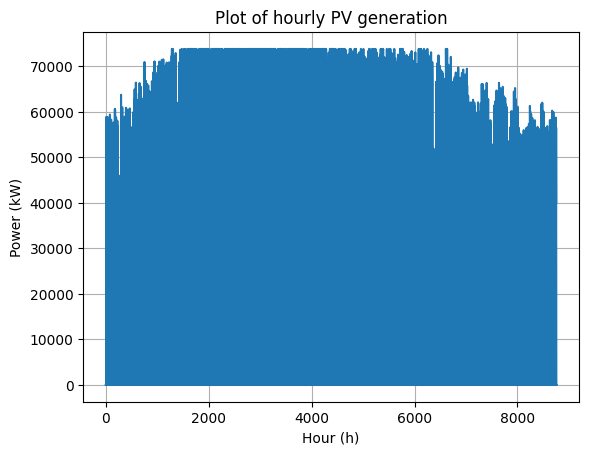

In [22]:
#Execute model
pv_model.execute()

#Print annual energy
print(pv_model.Outputs.annual_energy)

#Plot hourly power production from system
# Data for plotting
power = pv_model.Outputs.gen

fig, ax = plt.subplots()
ax.plot(power[0:8761])

ax.set(xlabel='Hour (h)', ylabel='Power (kW)',
       title='Plot of hourly PV generation')
ax.grid()

fig.savefig("test.png")
plt.show()

In [23]:
# Connect to LCOE fixed charge rate calculator
lcoe_model = lcoe.default('FlatPlatePVLCOECalculator')
#Set capital cost
lcoe_model.SimpleLCOE.capital_cost = 100000000.0 #$
#Set annual operating cost 
lcoe_model.SimpleLCOE.fixed_operating_cost = 1200000.0 #$
#Set fixed charge rate (FCR)
lcoe_model.SimpleLCOE.fixed_charge_rate = 0.05
#Set annual energy
lcoe_model.SimpleLCOE.annual_energy = pv_model.Outputs.annual_energy
#Run model
lcoe_model.execute()
#Print LCOE output
print(lcoe_model.Outputs.lcoe_fcr, "cents/kWh")

0.026951377601721786 cents/kWh


In [24]:
#Parametric analysis
lcoe_bin = []
annual_energy_bin = []
#Analyze effect of tilt angle on annual energy
tilt_angles = [10, 15, 20, 25, 30, 35, 40, 45]

for i in tilt_angles:
    #Set tilt angle
    pv_model.SystemDesign.subarray1_tilt = i
    #Run model
    pv_model.execute()
    #Save annual energy result
    annual_energy_bin.append(pv_model.Outputs.annual_energy)
    #Update LCOE annual energy
    lcoe_model.SimpleLCOE.annual_energy = pv_model.Outputs.annual_energy
    #Run LCOE model
    lcoe_model.execute()
    #Save LCOE result
    lcoe_bin.append(lcoe_model.Outputs.lcoe_fcr)
    
print(annual_energy_bin, "kWh")
print(lcoe_bin, "cents/kWh")

[237933963.55523822, 240687761.55289537, 242504552.237943, 243552445.71269903, 243702920.37948003, 243388441.1605778, 242408571.10948473, 240655594.90925968] kWh
[0.026057650229327694, 0.025759514983222116, 0.025566530371424215, 0.025456529421649436, 0.025440811256367876, 0.025473683016481015, 0.025576653381615567, 0.025762958066018533] cents/kWh


In [25]:
# create a new instance of the PVsamv1 and battery model
pv_batt_model = pv.new() #battery model runs from within pvsamv1
#batt_model = batt.default('StandaloneBatteryResidential')

# get the inputs from the JSON file
with open( '/PV_battery_commercial_example_pvsamv1.json', 'r') as f:
        pv_batt_inputs = json.load( f )


# iterate through the input key-value pairs and set the module inputs
for k, v in pv_batt_inputs.items():
    if k != 'number_inputs':
        pv_batt_model.value(k, v)

### Battery Sizing Helper Function

There are special PySAM functions that can assist with certain parts of the model. The first we will cover is the battery modeling helper functions. This model takes the battery model and desired battery bank power (kW), capacity (kWh), and battery cell voltage values (with other optional battery specifications) to size the battery inputs for your system

For more information, see the [Battery Tools documentation](https://nrel-pysam.readthedocs.io/en/main/helper-tools.html#battery-tools)


```
files.BatteryTools.battery_model_sizing(model, desired_power, desired_capacity, desired_voltage, size_by_ac_not_dc=None, module_specs: dict = None, tol=0.05)
```



In [26]:
# Battery helper function
# Battery with 6 kW, 12.5 kWh, 3.6 V cells
batt_tools.battery_model_sizing(pv_batt_model, 6, 12.5, 3.6)
pv_batt_model.SolarResource.solar_resource_file = "/phoenix_az_33.450495_-111.983688_psmv3_60_tmy.csv"
pv_batt_model.execute()

In [27]:
# Grid model
grid_model = grid.from_existing(pv_batt_model)
print(grid_model.Load.load)
grid_model.execute()

(65.6374, 62.5244, 75.1593, 66.7696, 78.4194, 69.7381, 79.1304, 50.4748, 50.3969, 37.7489, 37.1335, 28.3751, 27.4458, 23.7839, 21.3821, 20.961, 26.3378, 42.4988, 44.2319, 50.8582, 50.5752, 57.2174, 54.77, 62.5655, 62.5466, 69.0273, 64.4617, 71.8981, 68.3173, 74.5008, 234.676, 217.896, 230.172, 191.794, 172.779, 165.046, 163.967, 149.935, 141.272, 139.715, 147.919, 155.912, 130.833, 132.272, 128.764, 130.137, 41.6166, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 41.6166, 163.928, 142.125, 168.956, 147.914, 139.89, 136.938, 140.046, 132.461, 127.632, 127.446, 136.442, 141.771, 114.75, 114.797, 108.864, 112.226, 41.6166, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 41.6166, 142.076, 124.442, 158.465, 139.534, 130.405, 127.095, 126.792, 121.982, 117.195, 117.09, 126.775, 131.461, 102.11, 102.849, 94.7595, 97.4781, 41.6166, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 38.9362, 41.6166, 120.517, 110.213, 150.037, 131.9, 122.468, 122.902, 124.274, 124.874, 120.462, 119.828, 

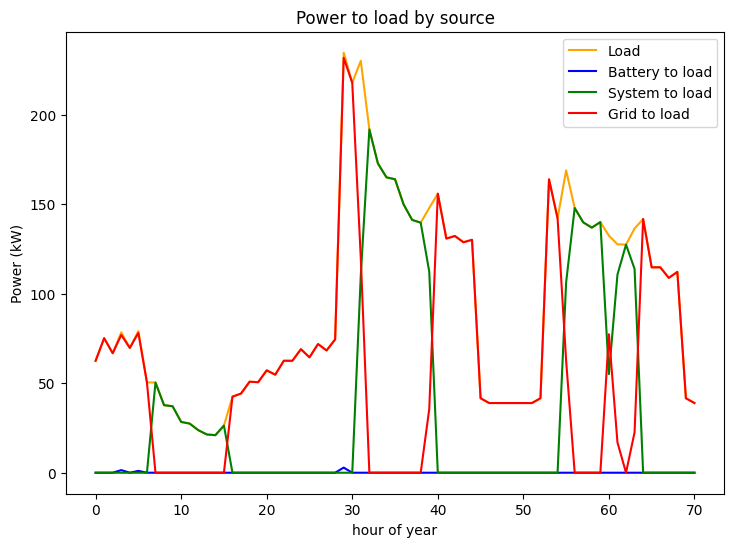

In [28]:
fig = plt.figure(figsize=(8.5, 6))
ax1 = fig.add_subplot(111)
ax1.set_title('Power to load by source')
ax1.set_ylabel('Power (kW)')
ax1.set_xlabel('hour of year')
dummy = ax1.plot(grid_model.Load.load[1:72], label="Load", color="orange")
dummy = ax1.plot(pv_batt_model.Outputs.batt_to_load[1:72], label="Battery to load", color="blue")
dummy = ax1.plot(pv_batt_model.Outputs.system_to_load[1:72], label="System to load", color="green")
dummy = ax1.plot(pv_batt_model.Outputs.grid_to_load[1:72], label="Grid to load", color="red")
label = True
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)